# Bonus1: Parallel Algorithms

### Name: Lucas Pontillo


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [221]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving diabetes to diabetes (17)
User uploaded file "diabetes" with length 75503 bytes


In [222]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

y = y.reshape(y.shape[0], 1)

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768, 1)


## 1.2. Partition to training and test sets

In [223]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [224]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[0.03643533 0.16957764 0.03230767 0.04983495 0.20245749 0.12133466
  0.01550925 0.11154387]]
test std = 
[[1.11290054 0.99270086 0.92231084 1.02775653 1.1675186  0.83403758
  1.13733165 1.10684131]]


## 1.4. Add a dimension of all ones

In [225]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


In [226]:
class Worker:
    
    def __init__ (self, x, y):
        self.x = x 
        self.y = y
        self.s = x.shape[0]
        self.d = x.shape[1]
        self.w = numpy.zeros((d, 1))
        
    def set_param(self , w): 
        self.w = numpy.array(w)
    
    def loss(self):
        yx = numpy.multiply(self.y, self.x)
        yxw = numpy.dot(yx, self.w)
        vec1 = numpy.exp(-yxw)
        vec2 = numpy.log(1 + vec1)
        return numpy.sum(vec2)

    def gradient(self):
        yx = numpy.multiply(self.y, self.x)
        yxw = numpy.dot(yx, self.w)
        vec1 = numpy.exp(yxw)
        vec2 = numpy.divide(yx, 1+vec1)
        g = -numpy.sum(vec2, axis=0).reshape(self.d, 1)
        return g
    
    def grad_descent(self, stepsize):
        g = self.gradient()
        self.w -= stepsize * g
        return self.w
    
    def stochastic_objective_gradient(self, w, xi, yi, lam):
        d = xi.shape[0]
        yx = yi * xi 
        yxw = float(numpy.dot(yx, w))
        loss = -yx.T / (1 + numpy.exp(yxw))
        g = loss + lam * w
        return g
    
    def sgd(self, stepsize, lam):
        n = self.x.shape[0]
        rand_indices = numpy.random.permutation(n)
        x_rand = self.x[rand_indices, :]
        y_rand = self.y[rand_indices, :]
        for i in range(n):
            xi = x_rand[i, :]
            yi = float(y_rand[i, :])
            g = self.stochastic_objective_gradient(self.w, xi, yi, lam)
            self.w -= stepsize * g
        stepsize *= 0.9     
        return self.w

In [227]:
class Server :
    def __init__(self, m, n, d):
        self.m = m
        self.n = n 
        self.d = d 
        self.w = numpy.zeros((d, 1))
        self.g = numpy.zeros((d, 1))
        self.v = numpy.zeros((d, 1))
        self.loss = 0 
        self.obj = 0 

    def broadcast(self): 
        return self.w

    def aggregate(self, grads, losses): 
        self.g = numpy.zeros((self.d, 1)) 
        self.loss=0
        for k in range(self.m):
            self.g += grads[k]
            self.loss += losses[k]
        
    def gradient (self, lam) :
        self.g = self.g / self.n + lam * self.w

    def objective (self, lam) :
        reg = lam / 2 * numpy.sum(self.w * self.w) 
        self.obj = self.loss / self.n + reg
        return self.obj
    
    def agd(self, alpha, beta): 
        self.v *= beta
        self.v += self.g
        self.w -= alpha * self.v

In [228]:
import math

def create_server_workers(m, x, y): 
    n, d = x.shape
    s = math.floor(n / m) 
    server = Server(m, n, d) 
    workers = []

    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        worker = Worker(x[indices, :], y[indices, :]) 
        workers.append(worker)
        
    return server, workers

In [229]:
def FedAvgGD(q):
    m = 4
    server,workers = create_server_workers(m, x_train , y_train)
    lam = 1E-5
    alpha = 1
    beta = 0.9
    max_epoch = 400
    step_size = 3E-2
    obj_values = []
    
    for t in range(max_epoch):
        w = server.broadcast()
        for i in range(m):
            workers[i].set_param(w)
        grads = []
        losses = []
        for i in range(m):
            for j in range(q):
              w_updt = workers[i].grad_descent(step_size) 
            g = w - w_updt   
            grads.append(g)
            l = workers[i].loss()
            losses.append(l)
        server.aggregate(grads, losses)
        server.gradient(lam)
        obj = server.objective(lam) 
        obj_values.append(obj)
        print('Objective function value = ' + str(obj))
        server.agd(alpha, beta)   
    return obj_values

In [230]:
def FedAvgSGD(q):
    m = 4
    server,workers = create_server_workers(m, x_train , y_train)
    lam = 1E-5
    alpha = 1
    beta = 0.9
    max_epoch = 400
    step_size = 3E-2
    obj_values = []

    for t in range(max_epoch):
        w = server.broadcast()
        for i in range(m):
            workers[i].set_param(w)
        grads = []
        losses = []
        for i in range(m):
            for j in range(q):
              w_updt = workers[i].sgd(step_size, lam) 
            g = w - w_updt   
            grads.append(g)
            l = workers[i].loss()
            losses.append(l)
        server.aggregate(grads, losses)
        server.gradient(lam)
        obj = server.objective(lam) 
        obj_values.append(obj)
        print('Objective function value = ' + str(obj))
        server.agd(alpha, beta)  
    return obj_values

In [231]:
print('GD1: ')
GD_1_obj = FedAvgGD(1)
print('GD8')
GD_8_obj = FedAvgGD(8)
print('SGD1')
SGD_1_obj = FedAvgSGD(1)
print('SGD8')
SGD_8_obj = FedAvgSGD(8)

GD1: 
Objective function value = 0.49181824881520286
Objective function value = 0.49026148230891553
Objective function value = 0.48739573117864143
Objective function value = 0.4835241384946612
Objective function value = 0.47898666837608034
Objective function value = 0.4741367338170791
Objective function value = 0.4693111245553378
Objective function value = 0.4647972327477656
Objective function value = 0.46080549346380195
Objective function value = 0.45745481779481056
Objective function value = 0.45477461104061545
Objective function value = 0.45272123651430074
Objective function value = 0.4512026632522143
Objective function value = 0.45010412470845995
Objective function value = 0.4493093905744176
Objective function value = 0.4487151039590621
Objective function value = 0.44823813699380777
Objective function value = 0.4478174098503174
Objective function value = 0.4474121119941806
Objective function value = 0.44699809424343456
Objective function value = 0.4465637327552834
Objective functio

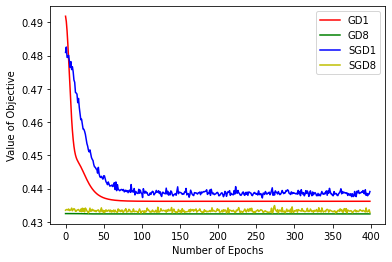

In [232]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(len(GD_1_obj))

plt.plot(epochs, GD_1_obj, '-r', label='GD1')
plt.plot(epochs, GD_8_obj, '-g', label='GD8')
plt.plot(epochs, SGD_1_obj, '-b', label='SGD1')
plt.plot(epochs, SGD_8_obj, '-y', label='SGD8')
plt.xlabel('Number of Epochs')
plt.ylabel('Value of Objective')
plt.legend()
plt.show()